## Tracking sulfide saturation during magma evolution
- This Jupyter Notebook shows how to use the various functionalities of PySulfSat to track sulfide saturation during magma evolution
- This work is soon to be published as Liu et al. (in prep). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySulfSat as ss
import Thermobar as pt
pd.options.display.max_columns = None

In [2]:
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

## 1. Load sulfide data

In [3]:
Sulfide_in=pd.read_excel('Liu_Sulf_Compp.xlsx')
Sulfide_in.head()

,Sample,Sulfide,Averaging method,S,Fe,Ni,Cu,Fe/(Fe+Cu+Ni)
0,H14,H14_S1,average (n=3),34.365900,49.914425,2.323820,13.395820,0.760496
1,H14,H14_S2,average (n=3),34.691202,50.071840,2.474618,12.762410,0.766693
2,H14,H14_S3,single,35.557799,56.234839,2.981762,5.225494,0.872641
3,H14,H14_S4,average (n=3),33.705771,50.447033,2.400133,13.447063,0.760957
4,H14,H14_S5,average (n=3),32.949899,45.135301,2.868397,19.046367,0.673158


In [4]:
H14_Sulf=Sulfide_in.loc[Sulfide_in['Sample']=="H14"]

## 2. Load best fit liquid line of descent 
- This data is a Petrolog model
- The addition of the Liq suffix might seem a bit odd, but this allows use of liquid-only thermometers from the Python3 Thermobarometry tool Thermobar

In [5]:
Liqs=ss.import_data('Model9_BaliOnlyLang_Closedsystem_32kbar_NiCu_02.xlsx', 
            Petrolog=True)
Liqs.head()
## Because Ni and Cu are treated as trace elemnets, we can adjust their concentrations by a consatnt
Liqs['Ni_Liq_ppm']=Liqs['Ni_Liq_ppm']*1.1
Liqs['Cu_Liq_ppm']=Liqs['Cu_Liq_ppm']*(8/9)

We have replaced all missing liquid oxides and strings with zeros. 


## 3. Loading in measured data to compare to models
- Here we load in matrix glasses and melt inclusion compositions, again, all data from Liu et al. (in prep).

In [6]:
# Melt inclusions from Bali et al.
BMI=pd.read_excel('HoluMIs.xlsx', sheet_name=' 3.Bali Supplement')
# Matrix glasses from Liu et al. (in prep)
LG=pd.read_excel('HoluMIs.xlsx', sheet_name='4.Liu Matrix Glass Data')

In [7]:
LG_14=LG.loc[LG['Comment'].str.contains('H4')]

## 8. SCSS models using predicted sulfide composition
- First, lets use the Smythe et al. (2017) model to predict sulfide compositions, based on petrolog Ni and Cu models
- As petrolog treates these incompatibly, we can multiply Ni and Cu by a constant, as if we had run the model with more Ni and Cu, withot having to do the calculations here. These fudge factors provide the best fit to observed Ni and Cu data. 

In [8]:
Smythe_CalcSulf=ss.calculate_S2017_SCSS(df=Liqs, T_K=Liqs['T_K'], 
P_kbar=3.2, Fe_FeNiCu_Sulf="Calc_Smythe",
Fe3Fet_Liq=Liqs['Fe3Fet_Liq'], Ni_Liq=Liqs['Ni_Liq_ppm'], 
Cu_Liq=Liqs['Cu_Liq_ppm'])

- Now we use the Oneill (2021) model, first using their method for calculating sulfide composition, and then using the Smythe algorithm

In [9]:
ONeill_CalcSulf=ss.calculate_O2021_SCSS(df=Liqs, T_K=Liqs['T_K'], 
P_kbar=3.2, 
Fe_FeNiCu_Sulf="Calc_ONeill",
Ni_Liq=Liqs['Ni_Liq_ppm'], 
Cu_Liq=Liqs['Cu_Liq_ppm'],
Fe3Fet_Liq=Liqs['Fe3Fet_Liq'])

In [10]:
ONeill_CalcSulf['Fe_FeNiCu_Sulf_calc'].head()

0    0.583722
1    0.586319
2    0.589038
3    0.591746
4    0.594277
Name: Fe_FeNiCu_Sulf_calc, dtype: float64

## 9. Lets compare these predictions to measured sulfide compositions
- For each sulfide, we have calculated an equivalent MgO content based on the melt or crystal it is hosted within 

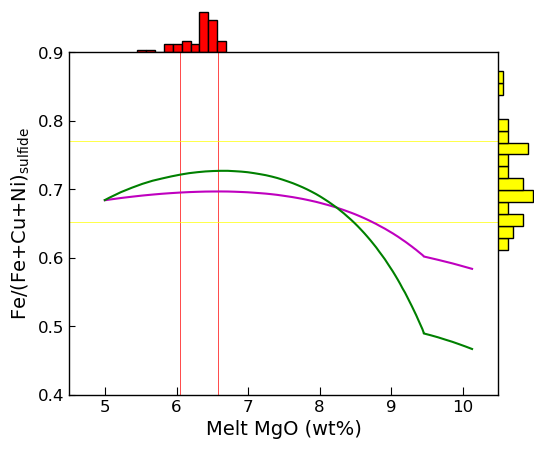

In [11]:
fig, (((ax3a),(ax3b)), ((ax4a, ax4b))) = plt.subplots(2, 2, figsize=(6,5),
                                    gridspec_kw={'height_ratios': [0.5, 4],
                                                 'width_ratios': [6, 0.5]
                                                })
plt.subplots_adjust(wspace=0, hspace=0)
ax3a.axis('off')
ax3b.axis('off')
ax4b.axis('off')

# Plot histogram of Mgo on ax3b
ax3a.hist(LG['MgO'],  ec='k', color='red')

# Plot histogram of sulifdes on ax3a
ax4b.hist(Sulfide_in['Fe/(Fe+Cu+Ni)'],  ec='k', 
          color='yellow', orientation='horizontal', bins=15)
# Plot models on Ax4a
ax4a.plot([np.nanmean(LG['MgO'])-np.nanstd(LG['MgO']),
           np.nanmean(LG['MgO'])-np.nanstd(LG['MgO'])],
                                           [0.4, 0.9], '-r', lw=0.5)
ax4a.plot([np.nanmean(LG['MgO'])+np.nanstd(LG['MgO']),
           np.nanmean(LG['MgO'])+np.nanstd(LG['MgO'])],
                                           [0.4, 0.9], '-r', lw=0.5)

ax4a.plot([4.5, 11],
 [np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)'])+np.nanstd(Sulfide_in['Fe/(Fe+Cu+Ni)']),
 np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)'])+np.nanstd(Sulfide_in['Fe/(Fe+Cu+Ni)'])],
          '-', color='yellow', lw=0.5)

ax4a.plot([4.5, 11],
 [np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)'])-np.nanstd(Sulfide_in['Fe/(Fe+Cu+Ni)']),
 np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)'])-np.nanstd(Sulfide_in['Fe/(Fe+Cu+Ni)'])],
          '-', color='yellow', lw=0.5)

ax4a.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['Fe_FeNiCu_Sulf_calc'], '-m')
ax4a.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['Fe_FeNiCu_Sulf_calc'], '-g')


ax3a.set_xlim([4.5, 10.5])
ax4a.set_xlim([4.5, 10.5])
ax4b.set_ylim([0.4, 0.9])
ax4a.set_ylim([0.4, 0.9])
ax4a.set_xlabel('Melt MgO (wt%)')
ax4a.set_ylabel('Fe/(Fe+Cu+Ni)$_{sulfide}$')
fig.savefig('SulfComp.png', dpi=200)
# Plot a fill between 

## Performing calculations using average measured sulfide content

In [13]:
Smythe_MeasSulf=ss.calculate_S2017_SCSS(df=Liqs, T_K=Liqs['T_K'], 
    Fe3Fet_Liq=Liqs['Fe3Fet_Liq'],                                         
P_kbar=3.2, Fe_FeNiCu_Sulf=np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)']))

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
You havent entered a value for Ni_FeNiCu_Sulf and Cu_FeNiCu_Sulf so we cant calculate the non-ideal SCSS


In [14]:
ONeill_MeasSulf=ss.calculate_O2021_SCSS(df=Liqs, T_K=Liqs['T_K'], 
P_kbar=3.2, 
Fe_FeNiCu_Sulf=np.nanmean(Sulfide_in['Fe/(Fe+Cu+Ni)']),
Fe3Fet_Liq=Liqs['Fe3Fet_Liq'])

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


In [15]:
# bit of S6+
s6_corr_10=1/(1-10/100)
s6_corr_10

1.1111111111111112

## Calculating fractional crystallization path

In [16]:
S_init=790
Calc_S_incom=ss.crystallize_S_incomp(S_init=S_init, F_melt=Liqs['Melt_%_magma']/100)
Calc_S_incom.head()

0    790.079008
1    798.020102
2    806.201424
3    814.467416
4    822.982677
Name: Melt_%_magma, dtype: float64

## Calculating amount of sulfide removed

In [20]:
S_Sulf=np.nanmean(H14_Sulf['S'])*10000
S_Sulf_Err=np.std(H14_Sulf['S'])*10000


S_Rem_ON_S2=ss.calculate_mass_frac_sulf(S_model=ONeill_MeasSulf['SCSS2_ppm'], 
                               S_init=S_init, 
                               F_melt=Liqs['Melt_%_magma']/100, 
                               S_sulf=S_Sulf)
S_Rem_ON_S6=ss.calculate_mass_frac_sulf(S_model=ONeill_MeasSulf['SCSS2_ppm']*s6_corr_10, 
                               S_init=S_init, 
                               F_melt=Liqs['Melt_%_magma']/100, 
                               S_sulf=S_Sulf)
S_Rem_Smythe=ss.calculate_mass_frac_sulf(S_model=Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017'], 
                               S_init=S_init, 
                               F_melt=Liqs['Melt_%_magma']/100, 
                               S_sulf=S_Sulf)

# Minus 1 sigma, if also do sigma on S, min value, max S in sulf
S_Rem_Smythe_minus1sig=ss.calculate_mass_frac_sulf(
S_model=Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017']-
Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017_1sigma'],
S_init=S_init, 
F_melt=Liqs['Melt_%_magma']/100, 
S_sulf=S_Sulf-S_Sulf_Err)


S_Rem_Smythe_plus1sig=ss.calculate_mass_frac_sulf(
S_model=Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017']+
Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017_1sigma'],
                               S_init=S_init, 
                               F_melt=Liqs['Melt_%_magma']/100, 
S_sulf=S_Sulf+S_Sulf_Err)

# To convert from mass to volume
M_Factor=(2804/4200)

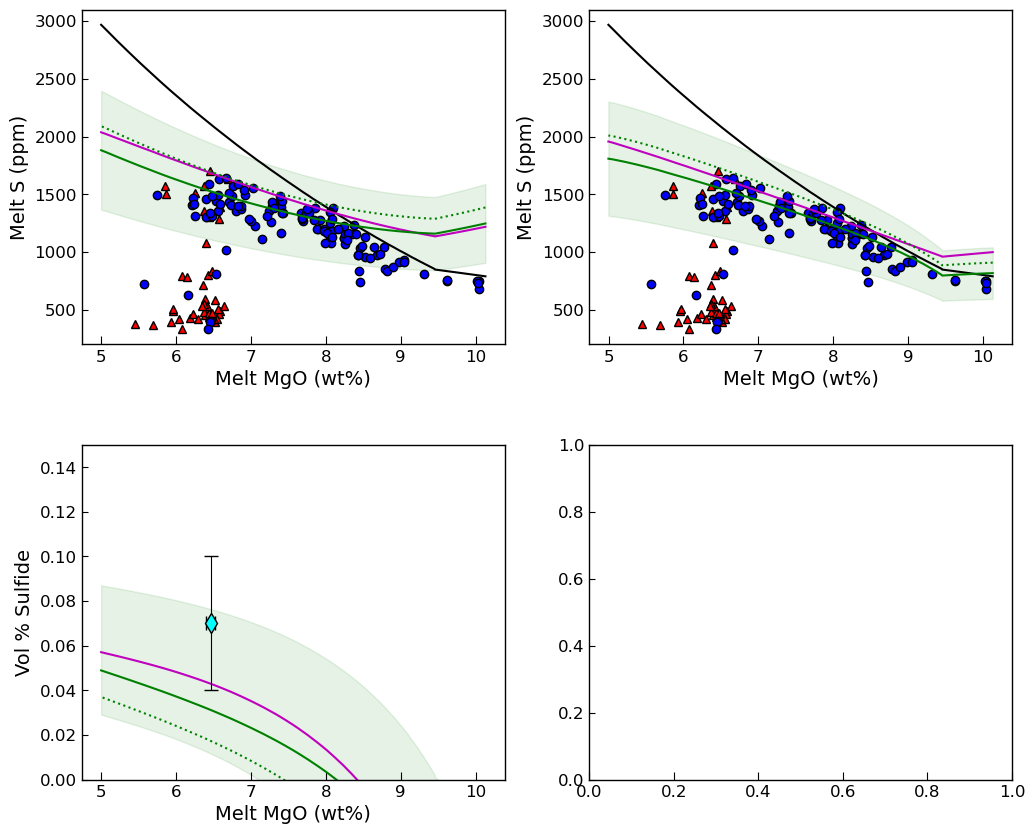

In [25]:
## Rset of the plots
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (12,10)) # adjust dimensions of figure here

# Fixed sulfide
ax0.plot(LG['MgO'], LG['S'], '^k', mfc='red', ms=6)
ax0.plot(BMI['MgO'], BMI['S-ppm'], 'ok', mfc='blue', ms=6)
ax0.plot(Liqs['MgO_Liq'], Calc_S_incom, '-k')
ax0.plot(ONeill_MeasSulf['MgO_Liq'], ONeill_MeasSulf['SCSS2_ppm'],
         '-m')
ax0.plot(Smythe_MeasSulf['MgO_Liq'], Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017'],
         '-g')
ax0.plot(Smythe_MeasSulf['MgO_Liq'], s6_corr_10*Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017'],
         ':g')
xfill=Smythe_MeasSulf['MgO_Liq']
y2fill_pap=(Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017']+
Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017_1sigma'])
y1fill_pap=(Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017']-
Smythe_MeasSulf['SCSS_ideal_ppm_Smythe2017_1sigma'])
ax0.fill_between(xfill, y1fill_pap, y2fill_pap, 
                 where=y1fill_pap < y2fill_pap, interpolate=True, 
                 color='green', alpha=0.1)

# Calculated sulfide
ax1.plot(LG['MgO'], LG['S'], '^k', mfc='red', ms=6)
ax1.plot(BMI['MgO'], BMI['S-ppm'], 'ok', mfc='blue', ms=6)
ax1.plot(Liqs['MgO_Liq'], Calc_S_incom, '-k')
ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm'],
         '-m')
ax1.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'],
         '-g')
ax1.plot(Smythe_CalcSulf['MgO_Liq'], s6_corr_10*Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'],
         ':g')
xfill=Smythe_CalcSulf['MgO_Liq']
y2fill_pap=(Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']+
Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'])
y1fill_pap=(Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']-
Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'])
ax1.fill_between(xfill, y1fill_pap, y2fill_pap, 
                 where=y1fill_pap < y2fill_pap, interpolate=True, ec=None,
                 color='green', alpha=0.1)

## Amount of sulfide fractionated
ax2.plot(Liqs['MgO_Liq'], 100*S_Rem_ON_S2*M_Factor, '-g')
ax2.plot(Liqs['MgO_Liq'], 100*S_Rem_ON_S6*M_Factor, ':g')
ax2.plot(Liqs['MgO_Liq'], 100*S_Rem_Smythe*M_Factor, '-m')
xfill=Liqs['MgO_Liq']
y2fill_pap=100*S_Rem_Smythe_minus1sig*M_Factor
y1fill_pap=100*S_Rem_Smythe_plus1sig*M_Factor
ax2.fill_between(xfill, y1fill_pap, y2fill_pap, 
                 where=y1fill_pap < y2fill_pap, interpolate=True, ec=None,
                 color='green', alpha=0.1)
ax2.set_ylim([0, 0.1])
ax2.errorbar(np.nanmean(LG_14['MgO']), 
             0.07,
             xerr=np.nanstd(LG_14['MgO']),
             yerr=0.03,
           fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=5)             

ax0.set_xlabel('Melt MgO (wt%)')
ax0.set_ylabel('Melt S (ppm)')
ax1.set_xlabel('Melt MgO (wt%)')
ax1.set_ylabel('Melt S (ppm)')
ax2.set_xlabel('Melt MgO (wt%)')
ax2.set_ylabel('Vol % Sulfide')
ax2.set_ylim([0, 0.15])
plt.subplots_adjust( hspace=0.3)
fig.savefig('Sulf_frac.png', dpi=200)